# Sales Lead Conversion Prediction for Tara Metal Industries
This notebook demonstrates a machine learning workflow to predict which sales leads are most likely to convert into customers using the provided dataset.

## 1. Import Required Libraries

In [6]:
# Import libraries for data science and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

## 2. Load and Explore the Dataset

In [25]:
# Load the dataset
df = pd.read_csv('tara_metal_leads_realistic_5000.csv')
display(df.head())
display(df.info())
display(df.describe())
display(df.isnull().sum())

,lead_id,company_name,company_type,region,product_interest,inquiry_channel,company_size,order_quantity_est,response_time_hrs,quotation_shared,catalog_requested,followups,conversion_status
0,TM1001,Madden and Sons,Retailer,North,Both,WhatsApp,Small,238,18,Yes,Yes,4,1
1,TM1002,Mora-Berry,Retailer,North,Kitchenware,Website,Large,626,4,Yes,No,1,1
2,TM1003,Mcdonald-Jones,Online Seller,North,Kitchenware,Reference,Medium,294,20,Yes,No,0,1
3,TM1004,Jones Inc,Retailer,East,Water Storage,Dealer,Medium,836,6,No,Yes,3,1
4,TM1005,Mitchell-George,Online Seller,Central,Water Storage,Dealer,Small,731,9,Yes,Yes,2,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   lead_id             5000 non-null   object
 1   company_name        5000 non-null   object
 2   company_type        5000 non-null   object
 3   region              5000 non-null   object
 4   product_interest    5000 non-null   object
 5   inquiry_channel     5000 non-null   object
 6   company_size        5000 non-null   object
 7   order_quantity_est  5000 non-null   int64 
 8   response_time_hrs   5000 non-null   int64 
 9   quotation_shared    5000 non-null   object
 10  catalog_requested   5000 non-null   object
 11  followups           5000 non-null   int64 
 12  conversion_status   5000 non-null   int64 
dtypes: int64(4), object(9)
memory usage: 507.9+ KB


None

,order_quantity_est,response_time_hrs,followups,conversion_status
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,500.076600,36.468400,2.478000,0.460000
std,285.862122,20.899549,1.717704,0.498447
min,10.000000,1.000000,0.000000,0.000000
25%,253.000000,18.000000,1.000000,0.000000
50%,491.000000,37.000000,2.000000,0.000000
75%,750.000000,54.000000,4.000000,1.000000
max,1000.000000,72.000000,5.000000,1.000000


lead_id               0
company_name          0
company_type          0
region                0
product_interest      0
inquiry_channel       0
company_size          0
order_quantity_est    0
response_time_hrs     0
quotation_shared      0
catalog_requested     0
followups             0
conversion_status     0
dtype: int64

In [17]:
df['conversion_status'].value_counts(normalize=True)


conversion_status
0    0.54
1    0.46
Name: proportion, dtype: float64

<Axes: xlabel='conversion_status', ylabel='followups'>

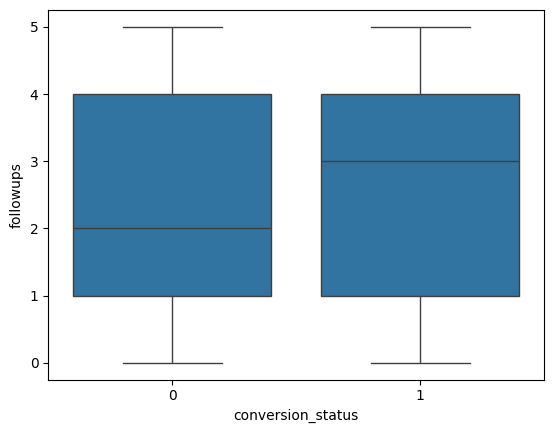

In [18]:
import seaborn as sns
sns.boxplot(x='conversion_status', y='followups', data=df)


## 3. Data Cleaning and Preprocessing

In [26]:
# Data Cleaning and Preprocessing
df = df.copy()
df = df.drop(['lead_id', 'company_name'], axis=1)  # Drop IDs and names (not useful for prediction)
# Fill missing values for categorical and numerical columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna('Unknown')
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())
# Define features and target
X = df.drop('conversion_status', axis=1)
y = df['conversion_status']
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
# Set up preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
 ])

In [27]:
# Feature Engineering: log-transform and interaction features
import numpy as np
X['log_order_quantity_est'] = np.log1p(X['order_quantity_est'])
X['log_response_time_hrs'] = np.log1p(X['response_time_hrs'])
X['followups_squared'] = X['followups'] ** 2
X['product_channel'] = X['product_interest'] + '_' + X['inquiry_channel']

In [28]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
# One-hot encode categorical features before SMOTE
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_enc = pd.DataFrame(ohe.fit_transform(X_train), columns=ohe.get_feature_names_out(X_train.columns), index=X_train.index)
X_test_enc = pd.DataFrame(ohe.transform(X_test), columns=ohe.get_feature_names_out(X_test.columns), index=X_test.index)

In [34]:
# Apply SMOTE to balance the training set (after encoding)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_enc, y_train)
print('Original training set shape:', y_train.value_counts().to_dict())
print('Resampled training set shape:', y_train_res.value_counts().to_dict())

Original training set shape: {0: 2160, 1: 1840}
Resampled training set shape: {1: 2160, 0: 2160}


In [ ]:
# Logistic Regression on SMOTE-resampled data
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)
y_pred_lr_res = lr.predict(X_test_enc)
from sklearn.metrics import classification_report, roc_auc_score
print('Logistic Regression (SMOTE):')
print(classification_report(y_test, y_pred_lr_res))
print('ROC AUC:', roc_auc_score(y_test, y_pred_lr_res))

## 4. Model Training and Evaluation

In [35]:
# Logistic Regression with pipeline
lr_pipeline = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
print('Logistic Regression:')
print(classification_report(y_test, y_pred_lr))
print('ROC AUC:', roc_auc_score(y_test, y_pred_lr))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       540
           1       0.68      0.66      0.67       460

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000

ROC AUC: 0.6950885668276972


In [22]:
# Random Forest with pipeline
rf_pipeline = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
print('Random Forest:')
print(classification_report(y_test, y_pred_rf))
print('ROC AUC:', roc_auc_score(y_test, y_pred_rf))

Random Forest:
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       540
           1       0.67      0.66      0.66       460

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000

ROC AUC: 0.6887681159420289


In [36]:
# Hyperparameter Tuning for Random Forest and XGBoost
from sklearn.model_selection import RandomizedSearchCV
param_dist_rf = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__class_weight': [None, 'balanced']
}
rf_search = RandomizedSearchCV(Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(random_state=42))]),
    param_distributions=param_dist_rf, n_iter=10, scoring='roc_auc', cv=3, random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)
print('Best Random Forest Params:', rf_search.best_params_)
print('Best Random Forest ROC AUC:', rf_search.best_score_)
y_pred_rf_best = rf_search.predict(X_test)
print(classification_report(y_test, y_pred_rf_best))
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_rf_best))

param_dist_xgb = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 5, 7, 10],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__subsample': [0.7, 0.8, 1.0],
    'clf__colsample_bytree': [0.7, 0.8, 1.0]
}
xgb_search = RandomizedSearchCV(Pipeline([('pre', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))]),
    param_distributions=param_dist_xgb, n_iter=10, scoring='roc_auc', cv=3, random_state=42, n_jobs=-1)
xgb_search.fit(X_train, y_train)
print('Best XGBoost Params:', xgb_search.best_params_)
print('Best XGBoost ROC AUC:', xgb_search.best_score_)
y_pred_xgb_best = xgb_search.predict(X_test)
print(classification_report(y_test, y_pred_xgb_best))
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_xgb_best))

Best Random Forest Params: {'clf__n_estimators': 200, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_depth': 5, 'clf__class_weight': 'balanced'}
Best Random Forest ROC AUC: 0.7638277241777806
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       540
           1       0.65      0.71      0.68       460

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000

Test ROC AUC: 0.6913848631239936


c:\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best XGBoost Params: {'clf__subsample': 0.7, 'clf__n_estimators': 100, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.8}
Best XGBoost ROC AUC: 0.7693780041140238
              precision    recall  f1-score   support

           0       0.71      0.72      0.72       540
           1       0.67      0.66      0.66       460

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000

Test ROC AUC: 0.6895330112721416


c:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:23:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 8. Model Selection and Saving the Best Model

In [37]:
# Save the best model pipeline (example: Random Forest)
import joblib
joblib.dump(lr_pipeline, 'best_lead_conversion_model.pkl')

['best_lead_conversion_model.pkl']

## 9. Next Steps and Business Recommendations
- Use the saved model in a web app for real-time lead scoring.
- Analyze feature importances to guide sales strategies.
- Continuously retrain the model as more data becomes available.